In [1]:
import os
import numpy as np
import numpy.random as npr
#import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

#keras = tf.keras
#tf.compat.v1.enable_eager_execution()

# from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


In [2]:
def SIRD_reduced_30_new(z, t, beta0, gamma, mu0, alpha):

    I, R, D = z
    
    #S0 = 1048000 * beta0
    S0 = 3.50860049e+01 * 100000 * beta0/10
    S = S0 - I - R - D
    #mu = max(mu0 * (1/(t+1)), kappa)
    mu = mu0/1000
    #mu = max(mu0 * (1/np.log(t+2)), kappa)
    #gamma = gamma*(1-(kappa/(t+1)))
    #gamma = gamma*(np.exp(t*(-0.03382921 + 4.81871454*gamma)))/(1 + np.exp(t*(-0.03382921 + 4.81871454*gamma)))
    #gamma = gamma*(np.exp(t - kappa)/(1 + np.exp(t - kappa)))
    #gamma = gamma*(np.exp((t - kappa)/7)/(1 + np.exp((t - kappa)/7)))
    #beta = beta0* np.exp(-(1.2534e-2 + 5.2702e-02 * beta0) * t)
    beta = beta0/10 * np.exp(-(alpha/1000) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma/100 * I - mu * I
    dR = gamma/100 * I
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt

def SIRD_reduced_30_new_ER(z, t, beta0, gamma, mu0, alpha):

    I, R, D = z
    
    S0 = 4.73021964e+01 * 100000 * beta0
    S = S0 - I - R - D
    mu = mu0
    beta = beta0 * np.exp(-(alpha) * t)
    dS = - beta * I * S / S0
    dI = beta * I * S / S0 - gamma * I - mu * I
    dR = gamma * I
    dD = mu * I

    dzdt = [dI, dR, dD]
    return dzdt


def plot_traj_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]

    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Recovered')
    d = plt.plot(x4, linewidth = width, label = 'Deceased')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Real SIRD')
    plt.title('nCov-19 data, Italy')
    plt.tight_layout()
    plt.savefig('sir.png', dpi=500)
    
    
def plot_traj_gray_SIRD(trajectories, width = 1.):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')
    d = plt.plot(x4, linewidth = width, color = 'lightgray')

In [31]:
Region = 'Lombardia'

flag_r = (Region=='Lombardia')

if flag_r:
    italy = pd.read_csv('RegionLombardia.csv')
else:
    italy = pd.read_csv('RegionVeneto.csv')

In [32]:
italy.fillna(0, inplace = True)

In [29]:
ext = 53+10
eff = 53+10
start = 260
SIRD_flag = True
italy = italy[start:]
italy = italy[:ext]
italy.reset_index(inplace = True, drop = True)

In [6]:
data_size = italy.shape[0]

batch_time = 20 # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'I'],italy.loc[i,'R'],italy.loc[i,'D']])
    extended_y = np.array(extended_y)
else:
    extended_y = []
    for i in range(ext):
        extended_y.append([italy.loc[i,'I'],italy.loc[i,'R']+italy.loc[i,'D']])
    extended_y = np.array(extended_y)

nonorm_y = extended_y.copy()

In [7]:
italy = italy[:eff]
italy.reset_index(inplace = True, drop = True)
#italy

In [8]:
data_size = italy.shape[0]

batch_time = 15  # tempo delle batches
niters = 500
batch_size = data_size - batch_time - 1

if SIRD_flag:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'I'],italy.loc[i,'R'],italy.loc[i,'D']])
    true_y = np.array(true_y)
else:
    true_y = []
    for i in range(data_size):
        true_y.append([italy.loc[i,'I'],italy.loc[i,'R']+italy.loc[i,'D']])
    true_y = np.array(true_y)

nonorm_y = true_y.copy()

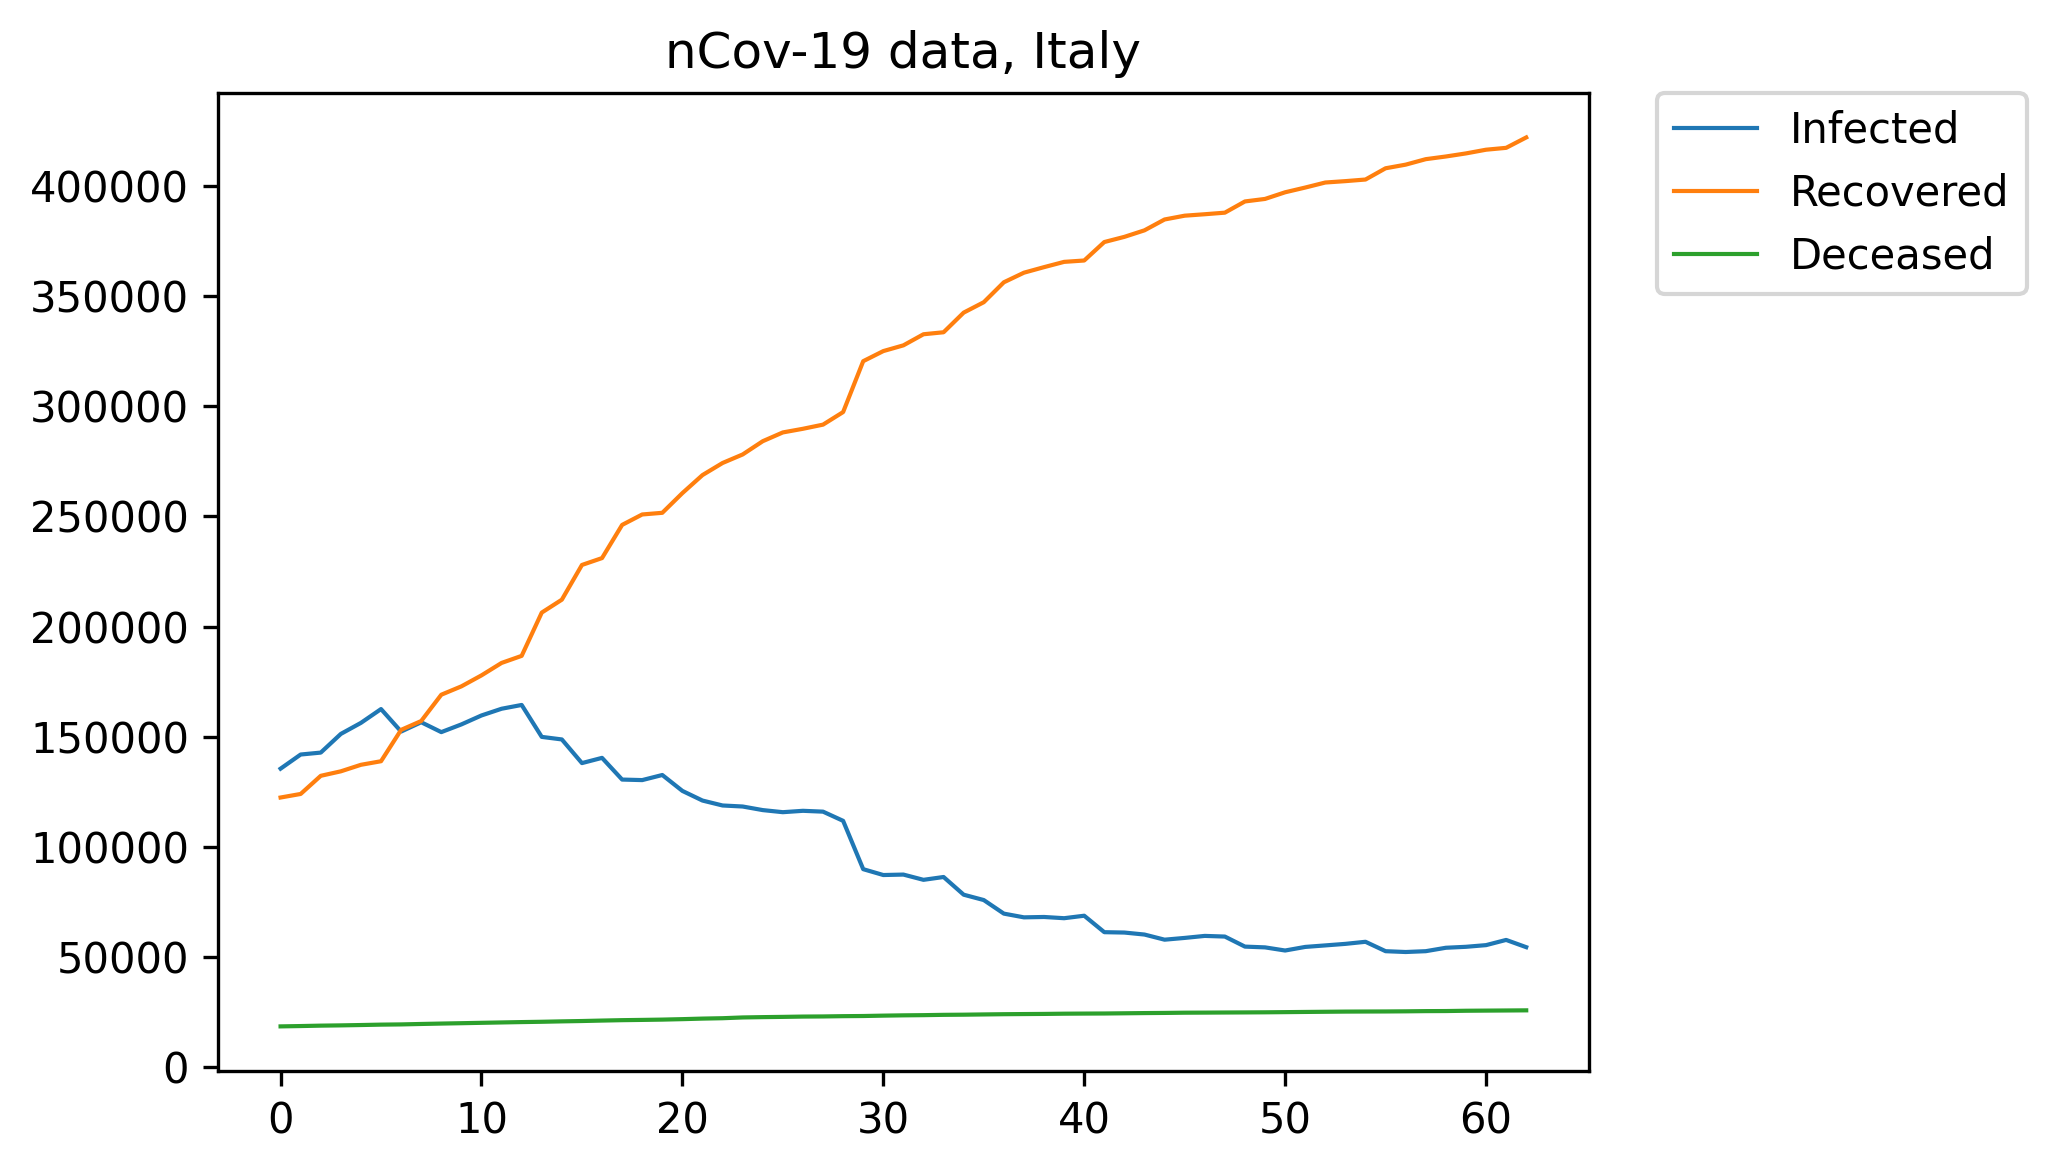

In [9]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(7, 4), dpi=150, facecolor='w', edgecolor='k')

plot_traj_SIRD(true_y)

In [10]:
china_start = np.float32(np.array(italy.iloc[0,0:4]))
print(china_start)

if flag_r:
    italy_start = tuple(china_start)
else:
    italy_start = tuple(china_start)
    
italy_start

[135505. 122410.  18571.]


(135505.0, 122410.0, 18571.0)

In [11]:
data_size = italy.shape[0]
t_grid = np.arange(data_size)

t_grid

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [12]:
from scipy import integrate, optimize

true_yy = np.append(true_y[:,0],true_y[:,1])
true_yy = np.append(true_yy,true_y[:,2])
    
def fit_odeint_reduced_30_new(x, beta0, gamma, mu0, alpha):
    fit = integrate.odeint(SIRD_reduced_30_new, italy_start, x, args=(beta0, gamma, mu0, alpha))
    fit_p = np.append(fit[:,0],fit[:,1])
    return np.append(fit_p,fit[:,2])

def fit_odeint_reduced_30_new_ER(x, beta0, gamma, mu0, alpha):
    fit = integrate.odeint(SIRD_reduced_30_new_ER, italy_start, x, args=(beta0, gamma, mu0, alpha))
    fit_p = np.append(fit[:,0],fit[:,1])
    return np.append(fit_p,fit[:,2])

if flag_r:
    popt, pcov = optimize.curve_fit(fit_odeint_reduced_30_new, xdata = t_grid, ydata =  true_yy, p0 = (0.43828327*10,  0.02015063*100,  0.30317892*10, 5), bounds=([0, 0, 0, -10], [10, 7, 5, 10]), method='trf')
else:
    popt, pcov = optimize.curve_fit(fit_odeint_reduced_30_new_ER, xdata = t_grid, ydata =  true_yy, p0 = (0.43828327,  0.02015063, 0.30317892, 0.1), bounds=([0, 0, 0, -1], [500, 7, 3, 100]), method='trf')

    
popt, pcov

(array([1.52966537, 4.90519009, 1.15023902, 6.01504818]),
 array([[ 5.55866589e-04, -5.51548938e-04,  5.73314469e-05,
          9.77131040e-02],
        [-5.51548938e-04,  2.18861564e-03,  4.27808727e-04,
         -1.05747661e-01],
        [ 5.73314469e-05,  4.27808727e-04,  4.88536116e-02,
         -1.42931787e-01],
        [ 9.77131040e-02, -1.05747661e-01, -1.42931787e-01,
          1.82201001e+01]]))

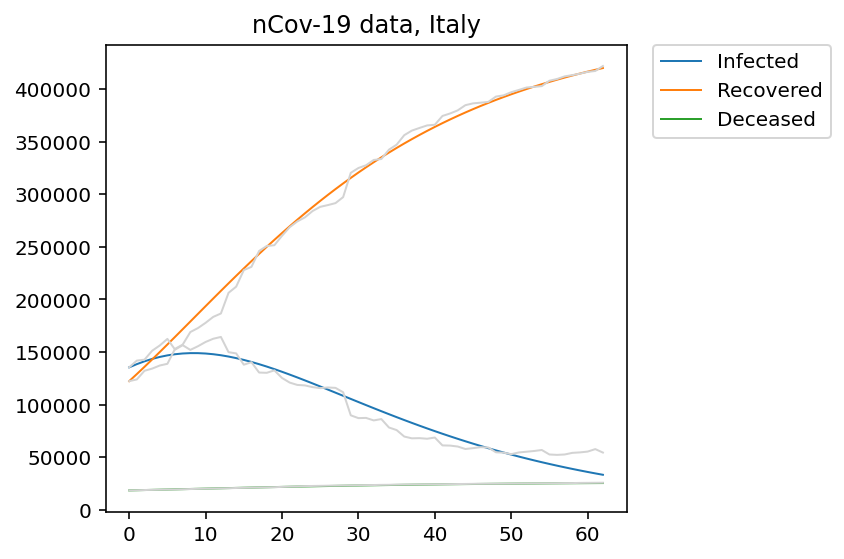

In [13]:
if flag_r:
    simul_yy =  odeint(SIRD_reduced_30_new, italy_start, np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIRD(simul_yy)
    plot_traj_gray_SIRD(extended_y)
    
else:
    simul_yy =  odeint(SIRD_reduced_30_new_ER, italy_start, np.arange(ext), args=tuple(np.reshape(popt,(1,-1))[0]))
    plot_traj_SIRD(simul_yy)
    plot_traj_gray_SIRD(extended_y)


In [14]:
extended_yy = np.append(extended_y[:,0],extended_y[:,1])
extended_yy = np.append(extended_yy,extended_y[:,2])

In [15]:
residuals = np.ravel(extended_yy) - fit_odeint_reduced_30_new(np.arange(ext), *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((np.ravel(extended_yy)-np.ravel(np.mean(extended_yy)))**2)

r_squared = 1 - (ss_res / ss_tot)

r_squared 

0.9970417375380813

Text(0.5, 1.0, 'Correlation Matrix')

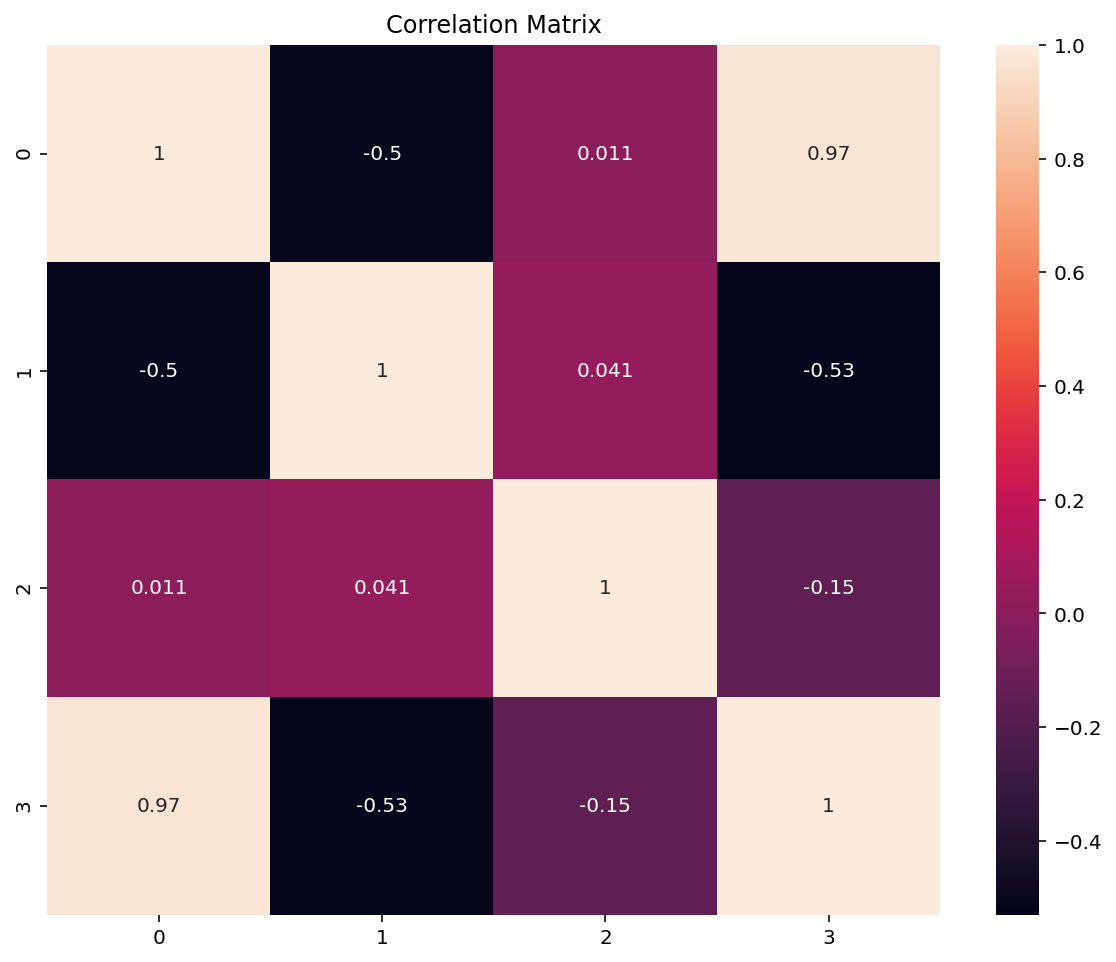

In [21]:
def compute_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

import seaborn as sns

corr = compute_corr(pcov)

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot = True)

plt.title("Correlation Matrix")


In [22]:
num_param = 4 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1



In [23]:
def compute_loss(params):
    residuals = true_yy - fit_odeint_reduced_30_new(np.arange(eff), *params)
    loss = np.sum(residuals**2)/(1e9)
    return loss

In [24]:
# These 2 functions sample from a truncated Gamma distribution by using the inverse cdf method. The first one
#  samples from the interval [a, +inf), the second one from [0, a)

import scipy.stats as sps
import numpy.random as npr

def trGamma_a_inf(shape, rate, trunc):
    interval = 1 - sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval + sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

def trGamma_0_a(shape, rate, trunc):
    interval = sps.gamma.cdf(trunc, a = shape, scale = 1/rate)
    yr = npr.rand(1)*interval
    xr = sps.gamma.ppf(yr, a = shape, scale = 1/rate)
    return(xr[0])

def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [25]:
def adaptive_gamma_sampling(true_center, shape, rate, quantile_1, quantile_2):
    if ((sps.gamma.cdf(true_center, a=shape, scale=1/rate) < quantile_1) | (sps.gamma.cdf(true_center, a=shape, scale=1/rate) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        loc = sps.gamma.mean(a=shape, scale=1/rate)
        if true_center > loc:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=trunc)
        else:
            trunc = loc + par*(true_center-loc)
            w_temp = trGamma_0_a(shape=shape, rate=rate, trunc=trunc)
    else:
        w_temp = sps.gamma.rvs(a = shape, scale=1/rate)
    
    return(w_temp)


def border_estimates_e_abc(eps, niters):
    
    
    # This function estimates the borders of the region containing the eps-approximate posterior through niters 
    #  iterations. It uses the empirical sampling method to get nearer to the correct acceptance region.
    #  This is only used to estimate borders, though it can estimate also the parameters in order to avoid 
    #  biases in the estimation.

    import scipy.stats as sps

    initial_loss = 0
    
    naccepted = 0
    
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(num_param)
    
    prior_means = np.array([4.3828327, 2.015063, 9.293047 , 10])  # Estimations from Italy (Adjusted for alpha because of hard lockdown)
    
    for i in tqdm(range(niters)):

        lambda_temp = [npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 10),npr.uniform(low = 0.5, high = 5)] #200

        alpha_quant = 0.25

        # Sampling of the candidate point from the priors
        
        w_temp[0] = adaptive_gamma_sampling(true_center=popt[0], shape=lambda_temp[0]*prior_means[0], rate=lambda_temp[0], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[1] = adaptive_gamma_sampling(true_center=popt[1], shape=lambda_temp[1]*prior_means[1], rate=lambda_temp[1], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[2] = adaptive_gamma_sampling(true_center=popt[2], shape=lambda_temp[2]*prior_means[2], rate=lambda_temp[2], quantile_1=alpha_quant, quantile_2=1-alpha_quant)
        w_temp[3] = adaptive_gaussian_sampling(true_center=popt[3], loc=0, scale=lambda_temp[3], quantile_1=alpha_quant, quantile_2=1-alpha_quant)      
        
        # After the sampling from the prior we go on by simulating the model
        # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)

        sim_loss = compute_loss(w_temp)
        loss.append(sim_loss)
        
        # Acceptance condition

        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3) and all(w_temp[pos] >= 0 for pos in range(3)):  
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    
    borders =  [np.min(parameters[:,i]) for i in range(num_param)]

    return(borders)

In [26]:
def e_abc_gamma_sampling(true_center, shape, rate, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    loc = sps.gamma.mean(a=shape, scale=1/rate)
    q = 0.25
    
    w_temp = trGamma_a_inf(shape=shape, rate=rate, trunc=border)
    
    return(w_temp)

In [27]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    
    # This function performs the empirical sampling from our method when the "true center" is too far from
    #  the center of the prior.
    
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.25) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.75)):
        a = 0
        b = 0
        if true_center > loc:
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [28]:
len(popt)

4

In [50]:
def preprocessing_e_abc(eps, niters, borders):

    # This function performs the first sampling from the region defined through the borders estimating function and
    #  returns the estimated parameters and the initializing weights, ([1,1,1,...,1] normalized)
    
    import scipy.stats as sps
    initial_loss = 0

    naccepted = 0

    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    prior_means = np.array([4.3828327, 2.015063, 9.293047 , 10])  # Estimations from Italy (Adjusted for alpha because of hard lockdown)
    
    for i in tqdm(range(niters)):

        lambda_temp = [npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 5),npr.uniform(low = 0.5, high = 7)] 

        #w_temp = [e_abc_gamma_sampling(popt[j], lambda_temp[j]*prior_means[j], lambda_temp[j], borders[j]) for j in range(len(popt))]
        
        w_temp[0] = e_abc_gamma_sampling(true_center=popt[0], shape=lambda_temp[0]*prior_means[0], rate=lambda_temp[0], border=borders[0])
        w_temp[1] = e_abc_gamma_sampling(true_center=popt[1], shape=lambda_temp[1]*prior_means[1], rate=lambda_temp[1], border=borders[1])
        w_temp[2] = e_abc_gamma_sampling(true_center=popt[2], shape=lambda_temp[2]*prior_means[2], rate=lambda_temp[2], border=borders[2])
        w_temp[3] = e_abc_gaussian_sampling(true_center=popt[3], loc=0, scale=lambda_temp[3], border=borders[3])      
        
        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        #if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3) and (w_temp[3] >= 2*w_temp[2]):
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1

    print('Acceptance rate: ', naccepted / niters)

    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]

    weights = np.ones(parameters.shape[0])/parameters.shape[0]
    
    return(parameters, weights)

In [51]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    
    # This function computes the weights associated to each parameter as described in https://arxiv.org/pdf/1106.6280.pdf
    
    prob_w = 1
    for i in range(para_num):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(para_num):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)

def normalize_weights(weights):
    
    # This function performs the normalization of weights
    
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

def sample_abc_smc_element(parameters, weights):
    
    # This function samples from the previous population according to the specified weights
    
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

def perturbation_kernel(sdev):
    
    # This function returns the perturbation from a Gaussian kernel with the specified standard deviation
    
    return([np.random.randn()*sdev[i] for i in range(para_num)])

In [56]:
def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    # This function returns the sampling according to the ABC-SMC with the weights associated to old parameters
    # specified in weights and the old parameters specified in old_parameters
    
    import scipy.stats as sps

    initial_loss = 0

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = np.zeros(para_num)

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        w_temp = np.resize(w_temp, (para_num,))

        sim_loss =  compute_loss(w_temp)
        loss.append(sim_loss)

        #if (np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3)) and (min(w_temp) >= 0) and (w_temp[3] >= 2*w_temp[2]):
        if (np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3)) and (min(w_temp[0:3]) >= 0):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            #lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5) # CAMBIARE LA FUNZIONE CHE PRENDE IN INGRESSO
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        
    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    #lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)

In [32]:
import scipy.stats as sps

eps = 20*compute_loss(popt)
niters = 3000

print("Borders estimation start...")
borders = border_estimates_e_abc(eps, 10*niters)

  0%|                                                                              | 32/30000 [00:00<01:36, 311.52it/s]

Borders estimation start...


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:31<00:00, 328.41it/s]

Acceptance rate:  0.1132


In [33]:
borders

[1.2361423444040505,
 3.0140164798388303,
 0.7272221425567537,
 0.11540490021476686]

In [49]:
print(borders)
print("Borders estimation completed, starting preprocessing...")
start, start_weights = preprocessing_e_abc(eps/2, 30*niters, borders)
print("Preprocessing completed, starting ABC-SMC")

  0%|                                                                              | 27/90000 [00:00<05:35, 267.82it/s]

[1.2361423444040505, 3.0140164798388303, 0.7272221425567537, 0.11540490021476686]
Borders estimation completed, starting preprocessing...


  3%|██▎                                                                         | 2748/90000 [00:08<04:31, 321.02it/s]

accepted


  4%|███▎                                                                        | 3876/90000 [00:12<04:23, 326.90it/s]

accepted


  5%|████                                                                        | 4808/90000 [00:14<04:22, 324.55it/s]

accepted


  6%|████▌                                                                       | 5338/90000 [00:16<04:21, 323.37it/s]

accepted


  8%|██████▏                                                                     | 7332/90000 [00:22<04:15, 323.22it/s]

accepted


  9%|██████▉                                                                     | 8229/90000 [00:25<04:11, 324.57it/s]

accepted


  9%|███████▏                                                                    | 8498/90000 [00:26<04:08, 327.69it/s]

accepted


 10%|███████▍                                                                    | 8828/90000 [00:27<04:09, 324.77it/s]

accepted


 10%|███████▋                                                                    | 9159/90000 [00:28<04:33, 295.26it/s]

accepted


 10%|███████▊                                                                    | 9255/90000 [00:28<04:23, 306.43it/s]

accepted


 12%|█████████▏                                                                 | 10975/90000 [00:34<04:04, 322.87it/s]

accepted


 14%|██████████▏                                                                | 12267/90000 [00:38<04:03, 319.05it/s]

accepted


 14%|██████████▍                                                                | 12529/90000 [00:38<03:55, 329.28it/s]

accepted


 15%|███████████▏                                                               | 13494/90000 [00:41<03:54, 326.93it/s]

accepted


 17%|████████████▍                                                              | 14894/90000 [00:46<03:57, 316.88it/s]

accepted


 17%|████████████▍                                                              | 14991/90000 [00:46<03:57, 315.82it/s]

accepted


 18%|█████████████▊                                                             | 16580/90000 [00:51<03:49, 320.18it/s]

accepted


 18%|█████████████▊                                                             | 16646/90000 [00:51<03:48, 320.73it/s]

accepted


 19%|██████████████▌                                                            | 17443/90000 [00:54<03:47, 319.59it/s]

accepted


 22%|████████████████▊                                                          | 20163/90000 [01:02<03:36, 321.95it/s]

accepted


 24%|██████████████████▏                                                        | 21787/90000 [01:07<03:31, 322.33it/s]

accepted


 28%|█████████████████████▎                                                     | 25540/90000 [01:19<03:20, 320.78it/s]

accepted


 29%|█████████████████████▋                                                     | 26099/90000 [01:21<03:20, 319.39it/s]

accepted


 30%|██████████████████████▎                                                    | 26821/90000 [01:23<03:14, 325.39it/s]

accepted


 32%|███████████████████████▊                                                   | 28642/90000 [01:28<03:10, 322.29it/s]

accepted


 32%|███████████████████████▉                                                   | 28775/90000 [01:29<03:08, 324.10it/s]

accepted


 37%|███████████████████████████▉                                               | 33537/90000 [01:44<03:02, 309.61it/s]

accepted


 38%|████████████████████████████▋                                              | 34474/90000 [01:47<02:59, 309.97it/s]

accepted


 40%|█████████████████████████████▊                                             | 35780/90000 [01:51<02:50, 318.73it/s]

accepted


 40%|█████████████████████████████▉                                             | 35878/90000 [01:51<02:52, 314.44it/s]

accepted
accepted


 41%|██████████████████████████████▍                                            | 36523/90000 [01:53<02:48, 317.38it/s]

accepted


 42%|███████████████████████████████▊                                           | 38244/90000 [01:59<02:40, 323.39it/s]

accepted


 43%|████████████████████████████████                                           | 38440/90000 [01:59<02:39, 322.31it/s]

accepted
accepted


 43%|████████████████████████████████▎                                          | 38804/90000 [02:00<02:37, 324.34it/s]

accepted


 45%|█████████████████████████████████▍                                         | 40086/90000 [02:05<02:33, 325.82it/s]

accepted


 45%|█████████████████████████████████▍                                         | 40186/90000 [02:05<02:32, 327.38it/s]

accepted


 45%|█████████████████████████████████▊                                         | 40578/90000 [02:06<02:36, 316.19it/s]

accepted


 46%|██████████████████████████████████▍                                        | 41399/90000 [02:09<02:35, 312.07it/s]

accepted


 47%|███████████████████████████████████▏                                       | 42207/90000 [02:11<02:31, 315.76it/s]

accepted


 47%|███████████████████████████████████▎                                       | 42336/90000 [02:12<02:30, 316.49it/s]

accepted


 48%|███████████████████████████████████▉                                       | 43091/90000 [02:14<02:27, 318.35it/s]

accepted


 48%|████████████████████████████████████                                       | 43320/90000 [02:15<02:27, 316.80it/s]

accepted


 49%|████████████████████████████████████▌                                      | 43943/90000 [02:17<02:26, 315.05it/s]

accepted
accepted


 49%|████████████████████████████████████▊                                      | 44104/90000 [02:17<02:28, 308.94it/s]

accepted


 50%|█████████████████████████████████████▏                                     | 44596/90000 [02:19<02:21, 321.27it/s]

accepted


 50%|█████████████████████████████████████▎                                     | 44793/90000 [02:19<02:22, 317.30it/s]

accepted


 50%|█████████████████████████████████████▊                                     | 45318/90000 [02:21<02:20, 318.64it/s]

accepted


 50%|█████████████████████████████████████▊                                     | 45383/90000 [02:21<02:19, 319.51it/s]

accepted


 51%|██████████████████████████████████████                                     | 45746/90000 [02:22<02:15, 325.54it/s]

accepted


 52%|██████████████████████████████████████▊                                    | 46542/90000 [02:25<02:15, 321.89it/s]

accepted


 56%|█████████████████████████████████████████▋                                 | 49966/90000 [02:36<02:05, 318.36it/s]

accepted


 56%|██████████████████████████████████████████                                 | 50494/90000 [02:37<02:01, 324.68it/s]

accepted


 56%|██████████████████████████████████████████▎                                | 50759/90000 [02:38<02:01, 322.67it/s]

accepted


 58%|███████████████████████████████████████████▏                               | 51786/90000 [02:41<01:57, 324.13it/s]

accepted


 59%|████████████████████████████████████████████▏                              | 53046/90000 [02:45<01:54, 322.75it/s]

accepted


 60%|████████████████████████████████████████████▊                              | 53772/90000 [02:47<01:54, 316.54it/s]

accepted


 61%|█████████████████████████████████████████████▋                             | 54812/90000 [02:51<01:51, 316.32it/s]

accepted


 63%|██████████████████████████████████████████████▉                            | 56397/90000 [02:56<01:42, 326.50it/s]

accepted


 65%|████████████████████████████████████████████████▊                          | 58649/90000 [03:03<01:38, 318.57it/s]

accepted


 65%|█████████████████████████████████████████████████                          | 58946/90000 [03:04<01:37, 319.67it/s]

accepted


 66%|█████████████████████████████████████████████████▋                         | 59690/90000 [03:06<01:30, 334.39it/s]

accepted


 68%|██████████████████████████████████████████████████▊                        | 61014/90000 [03:10<01:26, 333.62it/s]

accepted


 69%|███████████████████████████████████████████████████▍                       | 61669/90000 [03:12<01:25, 332.86it/s]

accepted


 71%|█████████████████████████████████████████████████████▎                     | 63982/90000 [03:19<01:17, 334.91it/s]

accepted


 72%|█████████████████████████████████████████████████████▉                     | 64766/90000 [03:21<01:15, 334.51it/s]

accepted


 74%|███████████████████████████████████████████████████████▍                   | 66544/90000 [03:26<01:09, 336.22it/s]

accepted
accepted


 74%|███████████████████████████████████████████████████████▋                   | 66857/90000 [03:27<01:07, 341.04it/s]

accepted


 75%|███████████████████████████████████████████████████████▉                   | 67099/90000 [03:28<01:08, 336.01it/s]

accepted


 77%|█████████████████████████████████████████████████████████▋                 | 69236/90000 [03:34<01:01, 339.47it/s]

accepted


 77%|█████████████████████████████████████████████████████████▊                 | 69338/90000 [03:35<01:01, 335.74it/s]

accepted


 77%|█████████████████████████████████████████████████████████▉                 | 69543/90000 [03:35<01:01, 334.44it/s]

accepted


 78%|██████████████████████████████████████████████████████████▏                | 69816/90000 [03:36<01:00, 332.96it/s]

accepted


 79%|███████████████████████████████████████████████████████████▏               | 70951/90000 [03:40<00:56, 335.93it/s]

accepted


 81%|████████████████████████████████████████████████████████████▍              | 72508/90000 [03:44<00:52, 336.24it/s]

accepted


 82%|█████████████████████████████████████████████████████████████▊             | 74218/90000 [03:49<00:46, 338.28it/s]

accepted


 84%|███████████████████████████████████████████████████████████████▏           | 75823/90000 [03:54<00:42, 332.24it/s]

accepted


 86%|████████████████████████████████████████████████████████████████▏          | 76996/90000 [03:58<00:38, 336.81it/s]

accepted


 87%|█████████████████████████████████████████████████████████████████          | 78072/90000 [04:01<00:35, 338.05it/s]

accepted


 87%|█████████████████████████████████████████████████████████████████          | 78141/90000 [04:01<00:35, 337.47it/s]

accepted


 87%|█████████████████████████████████████████████████████████████████▍         | 78523/90000 [04:02<00:34, 336.37it/s]

accepted


 87%|█████████████████████████████████████████████████████████████████▌         | 78625/90000 [04:02<00:33, 334.96it/s]

accepted


 88%|█████████████████████████████████████████████████████████████████▉         | 79141/90000 [04:04<00:31, 339.95it/s]

accepted


 89%|██████████████████████████████████████████████████████████████████▊        | 80137/90000 [04:07<00:29, 333.31it/s]

accepted
accepted


 91%|███████████████████████████████████████████████████████████████████▉       | 81585/90000 [04:11<00:24, 338.41it/s]

accepted


 91%|████████████████████████████████████████████████████████████████████▌      | 82275/90000 [04:13<00:22, 338.98it/s]

accepted
accepted


 92%|████████████████████████████████████████████████████████████████████▊      | 82548/90000 [04:14<00:22, 334.88it/s]

accepted


 92%|████████████████████████████████████████████████████████████████████▉      | 82686/90000 [04:14<00:21, 339.50it/s]

accepted
accepted


 92%|█████████████████████████████████████████████████████████████████████▏     | 83067/90000 [04:16<00:20, 340.63it/s]

accepted
accepted


 93%|█████████████████████████████████████████████████████████████████████▊     | 83759/90000 [04:18<00:18, 337.58it/s]

accepted


 96%|███████████████████████████████████████████████████████████████████████▉   | 86283/90000 [04:25<00:11, 332.27it/s]

accepted


 97%|████████████████████████████████████████████████████████████████████████▍  | 86930/90000 [04:27<00:09, 333.12it/s]

accepted


 97%|████████████████████████████████████████████████████████████████████████▋  | 87271/90000 [04:28<00:08, 337.13it/s]

accepted


 99%|██████████████████████████████████████████████████████████████████████████▎| 89131/90000 [04:34<00:02, 341.02it/s]

accepted


100%|███████████████████████████████████████████████████████████████████████████| 90000/90000 [04:36<00:00, 325.09it/s]

Acceptance rate:  0.0011222222222222222
Preprocessing completed, starting ABC-SMC


In [57]:
# cambiare i lambda anche in smc

parameters, weights = sample_abc_smc(eps/3, 2*niters, np.std(start, axis=0), start, start_weights)
#parameters, weights = sample_abc_smc(eps/6, 2*niters, np.std(parameters, axis=0), parameters, weights)
#parameters, weights = sample_abc_smc(eps/6, 8*niters, np.std(parameters, axis=0), parameters, weights)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:01<00:00, 97.74it/s]

Acceptance rate:  0.2816666666666667


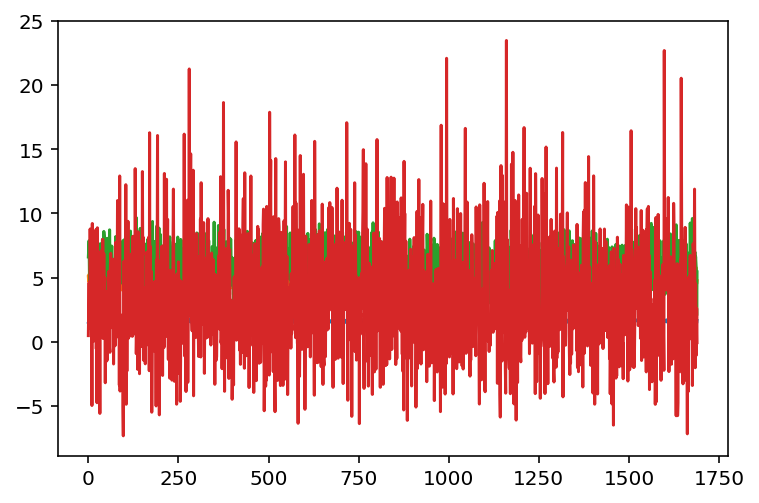

In [58]:
plt.plot(parameters)

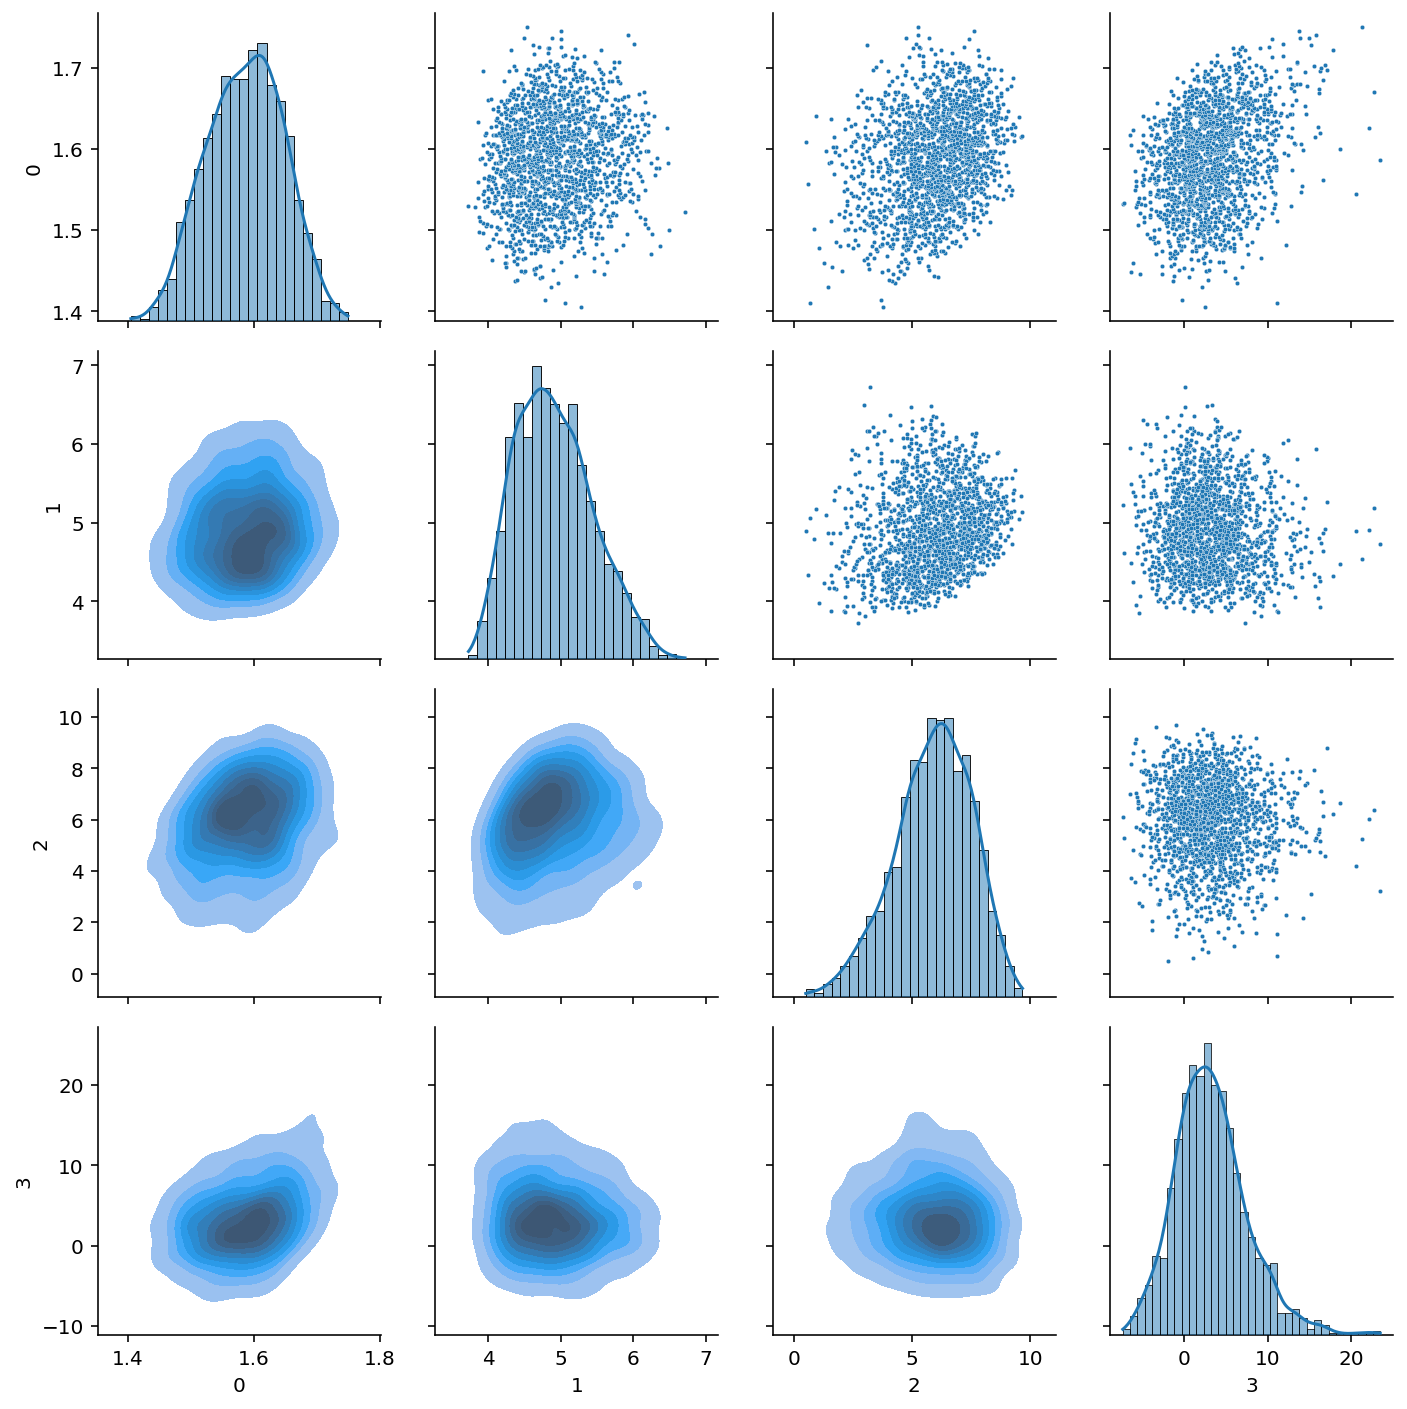

In [60]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

<AxesSubplot:title={'center':'x'}>

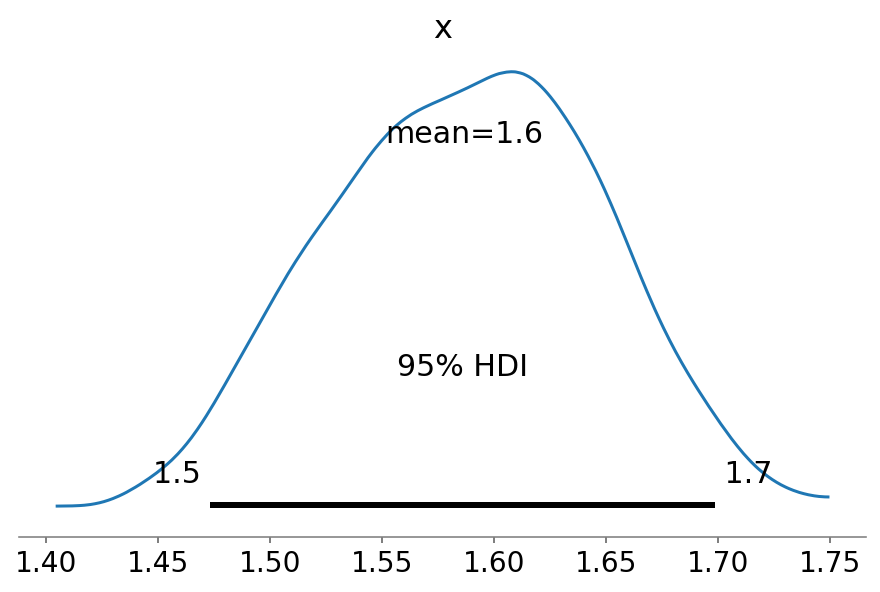

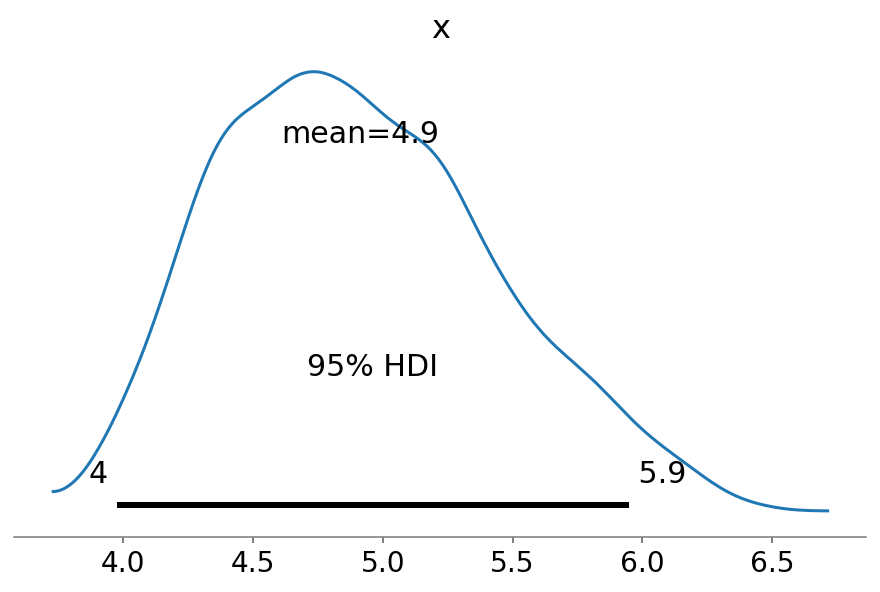

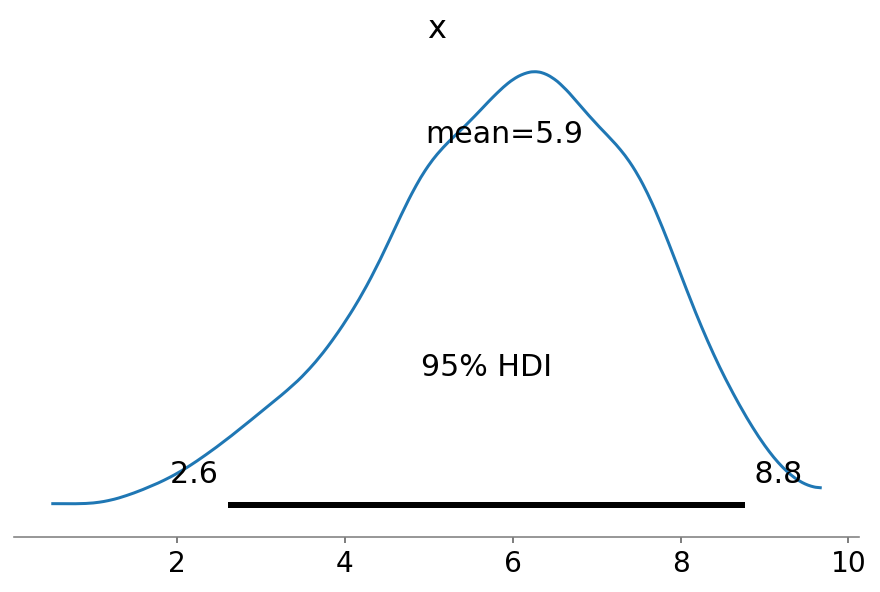

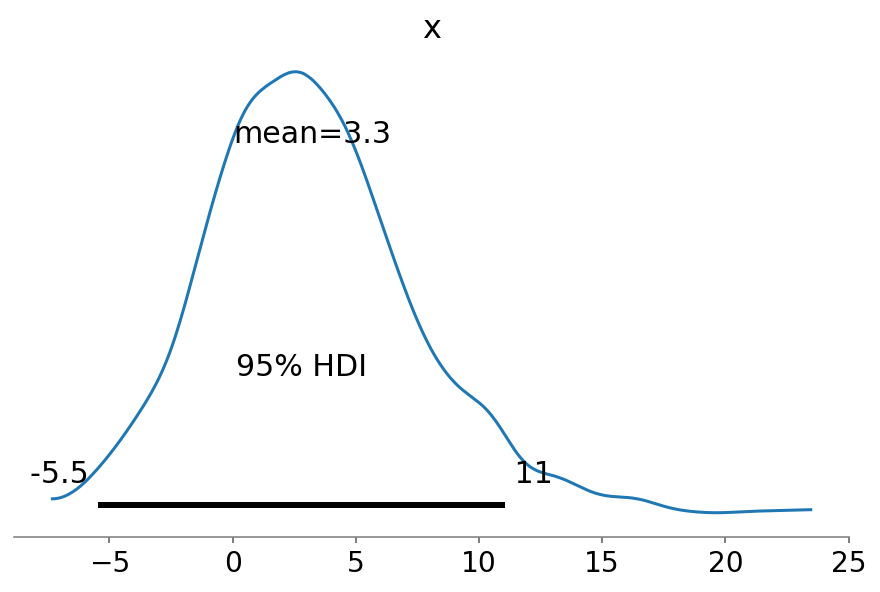

In [61]:
import arviz as az

az.plot_posterior(parameters[:,0],hdi_prob = 0.95)
az.plot_posterior(parameters[:,1],hdi_prob = 0.95)
az.plot_posterior(parameters[:,2],hdi_prob = 0.95)
az.plot_posterior(parameters[:,3],hdi_prob = 0.95)

In [159]:
#np.save('parameters_new.npy',parameters)
#np.save('weights_new.npy',weights)

In [16]:
parameters = np.load('parameters_lombardia.npy')
#weights = np.load('weights_new.npy')

In [23]:
def plot_traj_SIRD(trajectories, width = 1.5):
    x2 = trajectories[:,0]
    x3 = trajectories[:,1]
    x4 = trajectories[:,2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Real SIRD')
    plt.title('nCov-19 data, Lombardia')
    plt.tight_layout()
    plt.savefig('sir.png', dpi=500)
    
def plot_traj_SIRD2(trajectories, width=.7):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████| 1690/1690 [00:04<00:00, 378.07it/s]


135505.0 175466.72404605214
0 14
12


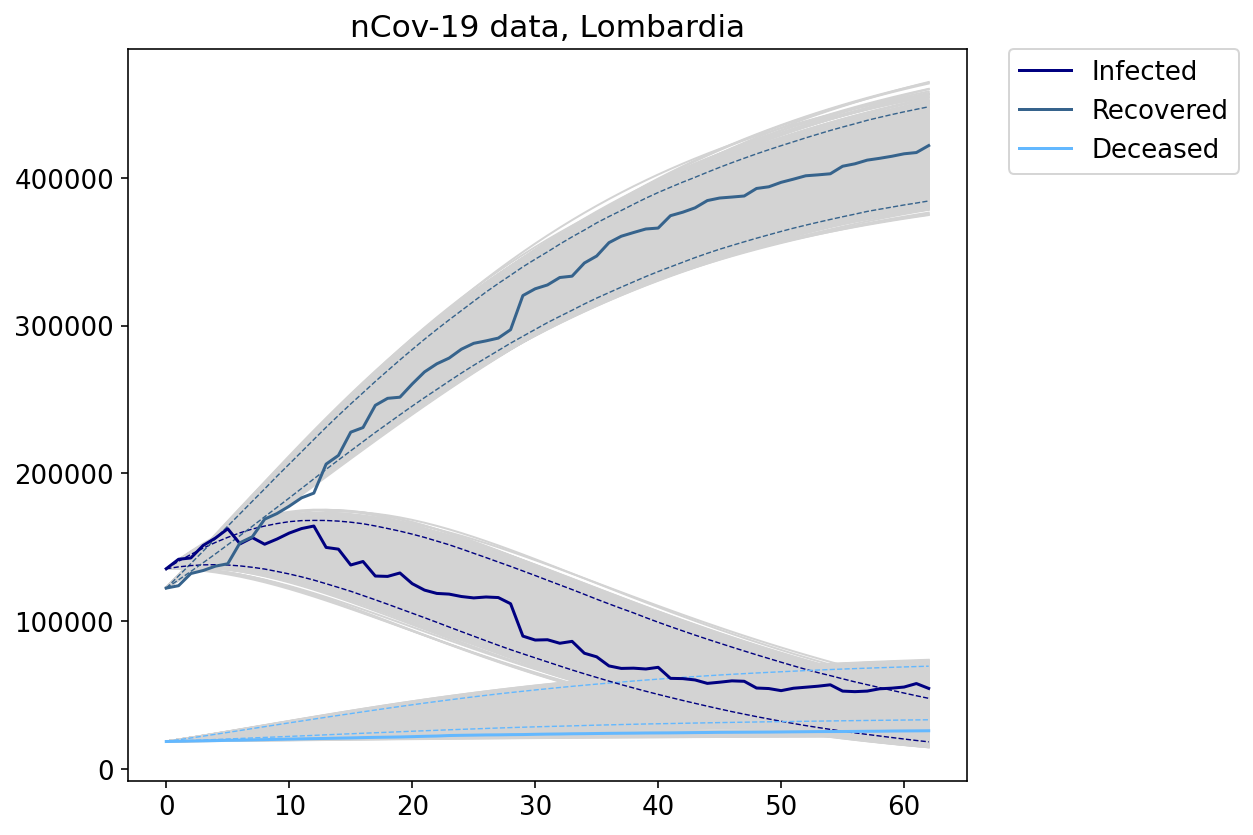

In [24]:
fig = plt.figure(figsize = (9,6))

plt.rcParams.update({'font.size': 13})

simul_all = []

peak = []
day_peak = []

trajectories2storeI = np.zeros(shape=(parameters.shape[0], ext))
trajectories2storeR = np.zeros(shape=(parameters.shape[0], ext))
trajectories2storeD = np.zeros(shape=(parameters.shape[0], ext))

for j in tqdm(range(parameters.shape[0])):
    simul_yy = odeint(SIRD_reduced_30_new, italy_start, np.arange(ext), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    trajectories2storeI[j,:] = simul_yy[:,0]
    trajectories2storeR[j,:] = simul_yy[:,1]
    trajectories2storeD[j,:] = simul_yy[:,2]
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0]))
    
simul_all = np.array(simul_all)
q95 = []
q05 = []
for i in range(eff):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])

q95 = np.array(q95)    
q05 = np.array(q05)  

plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(extended_y)

print(min(peak), max(peak))
print(min(day_peak), max(day_peak))
print(np.argmax(extended_y[:,0]))

plt.show()

In [25]:
# Test for
#  H0: alpha <= 0
#  H1: alpha > 0

p0 = np.sum(parameters[:,3] > 0)/parameters.shape[0]
BF10 = p0/(1-p0)

print(2*np.log(BF10))

'''
There's a slight evidence in favour of H1
'''

2.536854180219759


"\nThere's a slight evidence in favour of H1\n"

In [75]:
sps.ttest_1samp(parameters[:,3], 0, alternative='greater')

Ttest_1sampResult(statistic=31.05121907631474, pvalue=3.7058096049019713e-168)

In [79]:
np.save('parameters_lombardia.npy',parameters)
np.save('weights_lombardia.npy',weights)
np.savetxt("parsLombardia.csv", parameters, delimiter=",")
np.savetxt("trajILomb.csv", trajectories2storeI, delimiter=",")
np.savetxt("trajRLomb.csv", trajectories2storeR, delimiter=",")
np.savetxt("trajDLomb.csv", trajectories2storeD, delimiter=",")